# Import Modules

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

print("TensorFlow Version:", tf.__version__)
print("Keras Version:", keras.__version__)

2022-10-03 12:44:09.069106: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


TensorFlow Version: 2.4.0
Keras Version: 2.4.0


# Load Datasets for Demonstrations

## MNIST Fashion Dataset

In [2]:
# Load fashion MNIST dataset

fashion_mnist = keras.datasets.fashion_mnist
(mnist_X_train_full, mnist_y_train_full), (mnist_X_test, mnist_y_test) = fashion_mnist.load_data()

# print("Methods and attributes of fashion_mnist:\n", dir(fashion_mnist))
# print("Attributes values of fashion_mnist:\n", vars(fashion_mnist))

CLASS_NAMES = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [3]:
# Describe the MNIST dataset

print("Object Type of mnist_X_train_full:", type(mnist_X_train_full))
print("Shape of mnist_X_train_full:", mnist_X_train_full.shape)
print("Datatype of mnist_X_train_full:", mnist_X_train_full.dtype)
print("Maximum value of mnist_X_train_full:", mnist_X_train_full.max())
print("Minimum value of mnist_X_train_full:", mnist_X_train_full.min())
print("Averge value of mnist_X_train_full:", mnist_X_train_full.mean())
print("Median value of mnist_X_train_full:", np.median(mnist_X_train_full))

print()
print("Object Type of mnist_X_test:", type(mnist_X_test))
print("Shape of mnist_X_test:", mnist_X_test.shape)
print("Datatype of mnist_X_test:", mnist_X_test.dtype)
print("Maximum value of mnist_X_test:", mnist_X_test.max())
print("Minimum value of mnist_X_test:", mnist_X_test.min())
print("Averge value of mnist_X_test:", mnist_X_test.mean())
print("Median value of mnist_X_test:", np.median(mnist_X_test))

print()
print("Object Type of mnist_y_train_full:", type(mnist_y_train_full))
print("Shape of mnist_y_train_full:", mnist_y_train_full.shape)
print("Datatype of mnist_y_train_full:", mnist_y_train_full.dtype)
print("Maximum value of mnist_y_train_full:", mnist_y_train_full.max())
print("Minimum value of mnist_y_train_full:", mnist_y_train_full.min())
print("Averge value of mnist_y_train_full:", mnist_y_train_full.mean())
print("Median value of mnist_y_train_full:", np.median(mnist_y_train_full))
print("Unique values of mnist_y_train_full", np.unique(mnist_y_train_full))

print()
print("Object Type of mnist_y_test:", type(mnist_y_test))
print("Shape of mnist_y_test:", mnist_y_test.shape)
print("Datatype of mnist_X_test:", mnist_y_test.dtype)
print("Maximum value of mnist_y_test:", mnist_y_test.max())
print("Minimum value of mnist_y_test:", mnist_y_test.min())
print("Averge value of mnist_y_test:", mnist_y_test.mean())
print("Median value of mnist_y_test:", np.median(mnist_y_test))
print("Unique values of mnist_y_test", np.unique(mnist_y_test))

Object Type of mnist_X_train_full: <class 'numpy.ndarray'>
Shape of mnist_X_train_full: (60000, 28, 28)
Datatype of mnist_X_train_full: uint8
Maximum value of mnist_X_train_full: 255
Minimum value of mnist_X_train_full: 0
Averge value of mnist_X_train_full: 72.94035223214286
Median value of mnist_X_train_full: 0.0

Object Type of mnist_X_test: <class 'numpy.ndarray'>
Shape of mnist_X_test: (10000, 28, 28)
Datatype of mnist_X_test: uint8
Maximum value of mnist_X_test: 255
Minimum value of mnist_X_test: 0
Averge value of mnist_X_test: 73.14656658163265
Median value of mnist_X_test: 1.0

Object Type of mnist_y_train_full: <class 'numpy.ndarray'>
Shape of mnist_y_train_full: (60000,)
Datatype of mnist_y_train_full: uint8
Maximum value of mnist_y_train_full: 9
Minimum value of mnist_y_train_full: 0
Averge value of mnist_y_train_full: 4.5
Median value of mnist_y_train_full: 4.5
Unique values of mnist_y_train_full [0 1 2 3 4 5 6 7 8 9]

Object Type of mnist_y_test: <class 'numpy.ndarray'>
Sha

In [4]:
# Standardize MNIST datasets

mnist_X_valid, mnist_X_train = mnist_X_train_full[:5000] / 255.0, mnist_X_train_full[5000:] / 255.0
mnist_y_valid, mnist_y_train = mnist_y_train_full[:5000], mnist_y_train_full[5000:]

## California Housing Dataset

In [5]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
housing = fetch_california_housing()

dir(housing)

['DESCR', 'data', 'feature_names', 'frame', 'target', 'target_names']

In [7]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [8]:
house_X_train_full, house_X_test, house_y_train_full, house_y_test = train_test_split(housing.data, housing.target)
house_X_train, house_X_valid, house_y_train, house_y_valid = train_test_split(house_X_train_full, house_y_train_full)

scaler = StandardScaler()
house_X_train = scaler.fit_transform(house_X_train)
house_X_valid = scaler.transform(house_X_valid)
house_X_test = scaler.transform(house_X_test)

# Create Model Structure

- Structure Types
    - Sequential API: `keras.models.Sequential()`
    - Functional API: arbitrary model layers and structures

## Sequential Model

In [11]:
# Create a sequential model
seq_model = keras.models.Sequential(layers=[keras.layers.Flatten(input_shape=[28,28], #optional, auto implied when build or train if missing
                                                                 name="flatten"),
                                            
                                            keras.layers.Dense(300, 
                                                               activation="relu", 
                                                               name="relu_dense", 
                                                               kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=47), 
                                                               bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=47)
                                                              ),
                                            
                                            keras.layers.Dense(100, 
                                                               activation="tanh", 
                                                               name="tanh_dense",
                                                               kernel_initializer=keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=47), 
                                                               bias_initializer=keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=47),
                                                              ),
                                            
                                            keras.layers.Dense(10, activation="softmax", name="softmax_dense"),
                                            # If regression, the output layer can be keras.layers.Dense(1)
                                            # If binary classification, the output layer can be keras.layers.Dense(1, activation="sigmoid")
                                           ]
                                   )


# Add an layer
seq_model.add(keras.layers.Dense(50, activation="sigmoid", name="added_sigmoid"))

# # A model can be created using the add() method like this:
# seq_model = keras.models.Sequential()
# model.add(Layer1)
# model.add(Layer2)

# Remove the last layer
seq_model.pop()

# Show model summary
seq_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
relu_dense (Dense)           (None, 300)               235500    
_________________________________________________________________
tanh_dense (Dense)           (None, 100)               30100     
_________________________________________________________________
softmax_dense (Dense)        (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


2022-10-03 12:45:00.402205: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-03 12:45:00.402491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 12:45:00.402891: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 970 computeCapability: 5.2
coreClock: 1.253GHz coreCount: 13 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 208.91GiB/s
2022-10-03 12:45:00.402928: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-10-03 12:45:00.405811: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-10-03 12:45:00.405869: I tensorflow/stream_executor/platform/

## Nonsequential Models using Functional API

In [10]:
house_input = keras.layers.Input(shape=house_X_train.shape[1:]) # house_X_train.shape[1:] is (8,)
# For multiple inputs, create another input layer and add to the inputs=[] list in the keras.Model
house_hidden1 = keras.layers.Dense(30, activation="relu")(house_input)
house_hidden2 = keras.layers.Dense(30, activation="tanh")(house_hidden1)
house_concat = keras.layers.Concatenate()([house_input, house_hidden2])
house_output = keras.layers.Dense(1)(house_concat)

house_model = keras.Model(inputs=[house_input,], outputs=[house_output,])
# For multiple output:
# 1. Create the output layers
# 2. Add them in the outputs=[] list in keras.Model
# 3. Pass a list of losses to the loss=[] in Model.compile
# 4. Optional: pass a list of weights to loss_weights=[] in Model.compile
# 5. Prepare the same number of target values for: y_train, y_test, y_valid...
# 6. Model.evaluation returns: total loss, loss1, loss2...
# 7. Model.predict returns: pred1, pred2...

house_model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

house_history = house_model.fit(house_X_train, house_y_train, epochs=20,
                                validation_data=(house_X_valid, house_y_valid))
house_mse_test = house_model.evaluate(house_X_test, house_y_test)

house_X_new = house_X_test[:3]
house_y_new = house_y_test[:3]

house_y_pred = house_model.predict(house_X_new)

print("Acutals:", house_y_new)
print("Predictions:") 
print(house_y_pred)

Epoch 1/20


2022-10-03 12:35:32.657984: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-10-03 12:35:32.677169: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3298845000 Hz


  1/363 [..............................] - ETA: 2:13 - loss: 4.4546

2022-10-03 12:35:32.882267: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-10-03 12:35:33.059505: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


363/363 [==============================] - 1s 2ms/step - loss: 2.3957 - val_loss: 0.6364
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6495 - val_loss: 0.5594
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6106 - val_loss: 0.5253
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5634 - val_loss: 0.5001
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5274 - val_loss: 0.4812
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5044 - val_loss: 0.4674
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5155 - val_loss: 0.4549
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4940 - val_loss: 0.4470
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4663 - val_loss: 0.4393
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4714 - val_loss: 0.4338
Epoch 11/2

## Fetch Info & Parameters of Layers

In [11]:
# Show model layers
seq_model.layers

In [12]:
# Fetch layers
print(seq_model.layers[0].name)
print(seq_model.get_layer('tanh_dense') is seq_model.layers[2])

flatten
True


In [13]:
# Weights & Bias for each layer
weights, biases = seq_model.get_layer("tanh_dense").get_weights()

print("Shape of weights array:", weights.shape)
print("Shape of biases array:", biases.shape)

Shape of weights array: (300, 100)
Shape of biases array: (100,)


# Compile & Train Model

In [12]:
seq_model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=keras.optimizers.SGD(lr=0.01), # Or optimizer="sgd" if tuning of learning rate is not needed
                  metrics=["accuracy"]
                 )

In [15]:
seq_history = seq_model.fit(mnist_X_train, mnist_y_train, epochs=30, 
                            validation_data=(mnist_X_valid, mnist_y_valid, None), #the 3rd item is sample weight on validation data
                            # validation_split = 0.1 #if the dataset was not splitted
                            # sample_weight=, # weights on instances, supersedes class_weight
                            # class_weight=, # weights on target classes
                           )

Epoch 1/30
1719/1719 [==============================] - 3s 2ms/step - loss: 1.0489 - accuracy: 0.6732 - val_loss: 0.5203 - val_accuracy: 0.8236
Epoch 2/30
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5130 - accuracy: 0.8182 - val_loss: 0.4548 - val_accuracy: 0.8430
Epoch 3/30
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4557 - accuracy: 0.8373 - val_loss: 0.4189 - val_accuracy: 0.8528
Epoch 4/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4307 - accuracy: 0.8431 - val_loss: 0.3991 - val_accuracy: 0.8622
Epoch 5/30
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4041 - accuracy: 0.8569 - val_loss: 0.3880 - val_accuracy: 0.8598
Epoch 6/30
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3856 - accuracy: 0.8623 - val_loss: 0.3769 - val_accuracy: 0.8700
Epoch 7/30
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3755 - accuracy: 0.8659 - val_loss: 0.3795 - val_accuracy:

In [16]:
# Attributes of history objects
print(seq_history.params)
print()
print(seq_history.epoch)
print()
seq_history.history

{'verbose': 1, 'epochs': 30, 'steps': 1719}

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]



{'loss': [0.7543332576751709,
  0.49412187933921814,
  0.446273535490036,
  0.41956213116645813,
  0.39936599135398865,
  0.3853321075439453,
  0.3723609745502472,
  0.363101601600647,
  0.3533365726470947,
  0.3455921411514282,
  0.3379187285900116,
  0.33102095127105713,
  0.32497134804725647,
  0.31890758872032166,
  0.31294745206832886,
  0.3076480031013489,
  0.3027409315109253,
  0.2979724407196045,
  0.29230329394340515,
  0.28787365555763245,
  0.28325167298316956,
  0.2783519923686981,
  0.27476972341537476,
  0.27071020007133484,
  0.26644933223724365,
  0.26271507143974304,
  0.25862595438957214,
  0.2540304660797119,
  0.25174880027770996,
  0.24768967926502228],
 'accuracy': [0.751981794834137,
  0.8240181803703308,
  0.8415636420249939,
  0.8492545485496521,
  0.8578000068664551,
  0.8619999885559082,
  0.8669454455375671,
  0.8697454333305359,
  0.8741818070411682,
  0.8755090832710266,
  0.8781090974807739,
  0.8812000155448914,
  0.883436381816864,
  0.8854363560676575

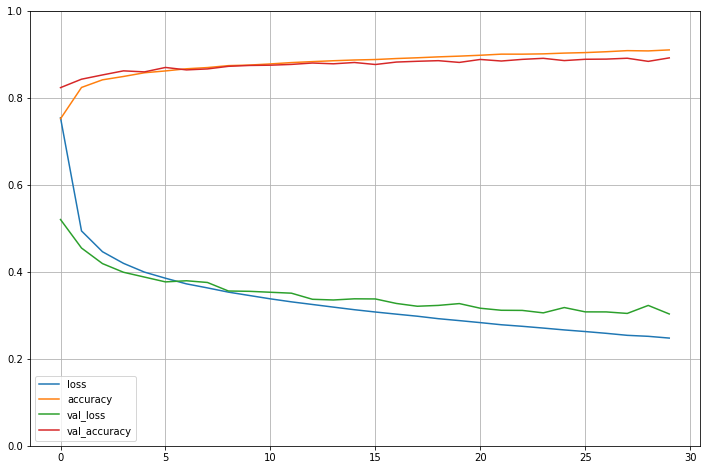

In [17]:
# Visualize the training history
pd.DataFrame(seq_history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

# Evaluate Model and Prediction

In [18]:
seq_model.evaluate(mnist_X_test, mnist_y_test)

313/313 [==============================] - 1s 1ms/step - loss: 0.6660 - accuracy: 0.8223


[0.6659903526306152, 0.8223000168800354]

In [19]:
mnist_X_new = mnist_X_test[:3]

# Predicted proability
mnist_y_proba = seq_model.predict(mnist_X_new)
mnist_y_proba.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [20]:
mnist_y_pred = np.argmax(mnist_y_proba, axis=-1)
print(mnist_y_pred)
print(np.array(CLASS_NAMES)[mnist_y_pred])

mnist_y_new = mnist_y_test[:3]
print(mnist_y_new)

[9 2 1]
['Ankle boot' 'Pullover' 'Trouser']
[9 2 1]


# Hyperparameter Tuning

# Save and Load

## Save and Load the trained models

In [21]:
seq_model.save("keras_fashion_mnist_classifier.h5")
seq_model_loaded = keras.models.load_model("keras_fashion_mnist_classifier.h5")

## Backward Compatibility between Versions

# Callbacks

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

- `keras.Model.fit(callbacks=[])` callbacks
    - Save checkpoints in training: `keras.callbacks.ModelCheckpoint(file_path="", save_best_only=True, save_freq="epoch")`
        - Saving model objects at certain frequency (default at the end of each epoch), optionally saving the best performing model
    - Early stopping: `keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)`
        - Stop the training if there is no improvement after `patience` number of epochs, optionally roll back to the best performing model so far
    - TensorBoard: `keras.callbacks.TensorBoard(log_dir="")
- Custom callbacks
    - Example of a custom callback that print the ratio between validation loss and training loss:
    
        ```Python
        class PrintTrainRatioCallback(keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs):
                print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))
        ```

In [22]:
# Code Example

class PrintTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}\n".format(logs["val_loss"] / logs["loss"]))

checkpoint_cb = keras.callbacks.ModelCheckpoint("fashion_checkpoint.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
print_ratio_cb = PrintTrainRatioCallback()

cb_seq_history = seq_model.fit(mnist_X_train, mnist_y_train, epochs=100, 
                               validation_data=(mnist_X_valid, mnist_y_valid), 
                               callbacks=[checkpoint_cb, early_stopping_cb, print_ratio_cb])

Epoch 1/100
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2448 - accuracy: 0.9116 - val_loss: 0.3060 - val_accuracy: 0.8898

val/train: 1.25

Epoch 2/100
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2405 - accuracy: 0.9128 - val_loss: 0.3182 - val_accuracy: 0.8870

val/train: 1.32

Epoch 3/100
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2368 - accuracy: 0.9141 - val_loss: 0.2947 - val_accuracy: 0.8928

val/train: 1.24

Epoch 4/100
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2336 - accuracy: 0.9146 - val_loss: 0.3082 - val_accuracy: 0.8864

val/train: 1.32

Epoch 5/100
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2308 - accuracy: 0.9172 - val_loss: 0.3059 - val_accuracy: 0.8868

val/train: 1.33

Epoch 6/100
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2272 - accuracy: 0.9174 - val_loss: 0.3047 - val_accuracy: 0.8910

val/train: 1.34

Epoch 7/100
1719/1719 

# TensorBoard

In [17]:
# Define directory structure to save log

import os
root_logdir = os.path.join(os.curdir, "log/fashion_mnist_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./log/fashion_mnist_logs/run_2022_10_03-12_52_57'

In [16]:
# Use TensorBoard Callback in training

tensorboard_cb = keras.callbacks.TensorBoard(log_dir=get_run_logdir())
tb_seq_history = seq_model.fit(mnist_X_train, mnist_y_train, epochs=30, 
                               validation_data=(mnist_X_valid, mnist_y_valid), 
                               callbacks=[tensorboard_cb])

Epoch 1/30
   1/1719 [..............................] - ETA: 5s - loss: 0.3777 - accuracy: 0.8438

2022-10-03 12:51:40.279900: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-10-03 12:51:40.279928: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-10-03 12:51:40.396435: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-10-03 12:51:40.396600: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed


 109/1719 [>.............................] - ETA: 6s - loss: 0.2340 - accuracy: 0.9149

2022-10-03 12:51:40.669416: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-10-03 12:51:40.669440: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-10-03 12:51:40.779282: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-10-03 12:51:40.779448: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2022-10-03 12:51:40.924101: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 79 callback api events and 67 activity events. 
2022-10-03 12:51:40.929480: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-10-03 12:51:40.931301: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./log/fashion_mnist_logs/run_2022_10_03-12_51_40/train/plugins/profile/2022_10_03_12_51_40
2022-10-03 12:51:40.932754: I tensorflow/core/profiler/rpc/clie

1719/1719 [==============================] - 3s 2ms/step - loss: 0.2425 - accuracy: 0.9136 - val_loss: 0.3053 - val_accuracy: 0.8902
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2387 - accuracy: 0.9140 - val_loss: 0.3007 - val_accuracy: 0.8922
Epoch 3/30
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2354 - accuracy: 0.9151 - val_loss: 0.2945 - val_accuracy: 0.8934
Epoch 4/30
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2318 - accuracy: 0.9156 - val_loss: 0.3148 - val_accuracy: 0.8844
Epoch 5/30
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2289 - accuracy: 0.9171 - val_loss: 0.3032 - val_accuracy: 0.8900
Epoch 6/30
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2254 - accuracy: 0.9174 - val_loss: 0.3013 - val_accuracy: 0.8948
Epoch 7/30
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2215 - accuracy: 0.9207 - val_loss: 0.2918 - val_accuracy: 0.8950
Epo

In [18]:
# Use % load_ext tensorboard if load on the first time
# Use %reload_ext tensorboard if already loaded before
%load_ext tensorboard 
%tensorboard --logdir ./log --port=8766

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 8766 (pid 4296), started 0:08:33 ago. (Use '!kill 4296' to kill it.)

# Keras Layers

## Input Layer

### Shape of Input Layer: Flatten or Not

## Dense Layer

In [ ]:
keras.layers.Dense(units, 
                   activation=None, 
                   kernel_initializer="glorot_uniform",
                   bias_initializer="zeros",
                  )

# Activation functions
- See https://keras.io/api/layers/activations/
    - "relu" or keras.activations.relu
    - "sigmoid" or keras.activations.sigmoid
    - "softmax" or keras.activations.relu
    - "softplus" or keras.activations.softplus
    - "softsign" or keras.activations.softsign
    - "tanh" or keras.activations.tanh
    - "selu" or keras.activations.selu
    - "elu" or keras.activations.elu
    - "exponential" or keras.activations.exponential

# Initializers 
- Initializers are used to intialize the weights & bias for each layer
- Parameters: `kernel_initializer` (weight) and `bias_initializer`
- See https://keras.io/api/layers/initializers/
    - `tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)` or `tf.keras.initializers.random_normal`
    - 

In [3]:
model = keras.models.Sequential(layers=[keras.Input(shape=(600,500)),
                                        keras.layers.Dense(units=1000,
                                                           activation="relu",
                                                           kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=47),
                                                           bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=47),
                                                          ),
                                        keras.layers.Dense(units=2000,
                                                           activation="tanh",
                                                           kernel_initializer=keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=47),
                                                           bias_initializer=keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=47),
                                                          ),
                                       ],
                                name=["norm_init","unif_init"]
                               )

norm_weight, norm_bias = model.layers[0].get_weights()
unif_weight, unif_bias = model.layers[1].get_weights()

print(norm_weight.shape)
print(norm_bias.shape)

print(unif_weight.shape)
print(unif_bias.shape)

model.summary()

(500, 1000)
(1000,)
(1000, 2000)
(2000,)
Model: "['norm_init', 'unif_init']"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 600, 1000)         501000    
_________________________________________________________________
dense_3 (Dense)              (None, 600, 2000)         2002000   
Total params: 2,503,000
Trainable params: 2,503,000
Non-trainable params: 0
_________________________________________________________________


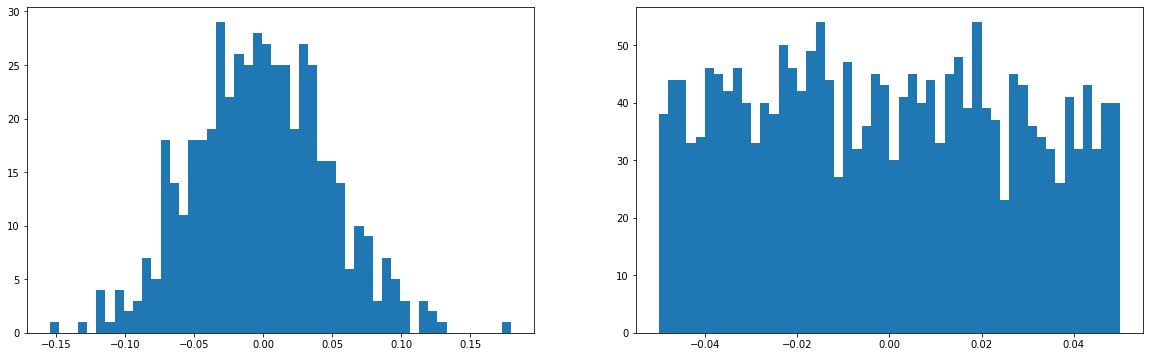

In [27]:
fig = plt.figure(figsize=[20,6])
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.hist(norm_weight[:,8],bins=50)
ax2.hist(unif_weight[10],bins=50)
plt.show()

# Loss Function

## Usecase for loss functions
- `loss="binary_crossentropy"` or `loss=keras.losses.BinaryCrossentropy`
    - binary-class, single-lable classification target with 2 classes
- `loss="sparse_categorical_crossentropy"` or `loss=keras.losses.SparseCategoricalCrossentropy`
    - multi-class, single-label (classes are exclusive) classification target with more than 2 classes
    - The targets are NOT one-hot encoded.
    - Example of a target for one instance: 4
- `loss="categorical_crossentropy"` or `loss=keras.losses.CategoricalCrossentropy`
    - multi-class, single-label (classes are exclusive) classification target with more than 2 classes
    - The targets are one-hot encoded.
    - Example of a target for one instance: [0.,0.,1.,0.]
- Multi-class, multi-label????
- Regression???

# Optimizers

# Metrics

- How metrics are related to loss?

# Utilities

- `keras.utils.to_categrical()` to convert sparse labels to one-hot vector labels